\begin{equation}
\omega = \Omega\, T_s
\end{equation}

\begin{equation}
\omega = \frac{2\pi k}{N},\; k=0, \dotsc, N-1
\end{equation}

\begin{equation}
X_d(\omega) = \frac{1}{T_s} \sum_{k=-\infty}^\infty X_c\biggl(\frac{\omega - 2\pi k}{T_s}\biggr)
\end{equation}

\begin{equation}
\text{rect}(t) =
\begin{cases}
1 & |t| \leq \frac{1}{2} \\ 
0 & \text{otherwise}
\end{cases}
\end{equation}

\begin{equation}
\text{sinc}(x) =
\begin{cases}
1 & x = 0 \\
\frac{\sin x}{x} & \text{otherwise}
\end{cases}
\end{equation}

\begin{equation}
\text{rect(t)} \overset{\mathfrak{F}}{\longleftrightarrow} \text{sinc}(\Omega/2)
\end{equation}

\begin{equation}
x(at) \overset{\mathfrak{F}}{\longleftrightarrow} \frac{1}{|a|} X_c\biggl(\frac{\Omega}{a}\biggr)
\end{equation}

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.fft
import scipy.special
import matplotlib.pyplot as plt

from pyinverse.axis import RegularAxis, FFTRegularAxis

In [3]:
a = 3.4
N = 129

In [4]:
axis_t = RegularAxis.linspace(-1, 1, N)

In [5]:
#d = 0.5
#Ts = 1/(d*N)
#axis_t = FFTRegularAxis(N, d=d).increasing_axis()

In [6]:
def rect(t):
    y = np.zeros_like(t)
    y[np.abs(t) < 0.5] = 1
    y[np.abs(t) == 0.5] = 0.5
    return y

In [7]:
x = rect(axis_t.centers * a)

<IPython.core.display.Javascript object>


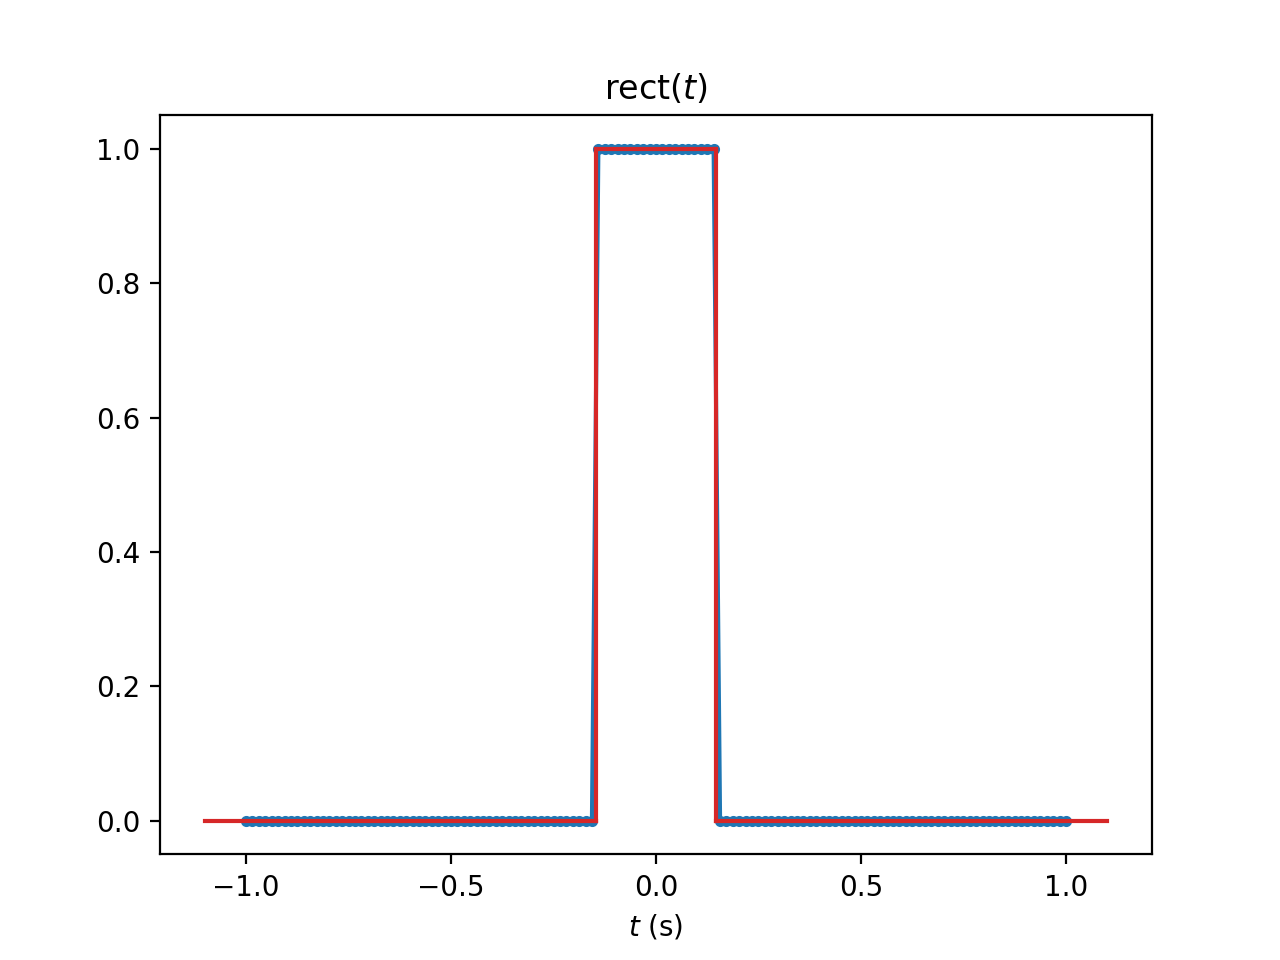

In [8]:
fig, ax = plt.subplots()
ax.plot(axis_t.centers, x, marker='.')
xmin, xmax = ax.get_xlim()
ax.plot([xmin, -1/(2*a)], [0, 0], c='C3')
ax.plot([-1/(2*a), -1/(2*a)], [0, 1], c='C3')
ax.plot([-1/(2*a), 1/(2*a)], [1, 1], c='C3')
ax.plot([1/(2*a), 1/(2*a)], [1, 0], c='C3')
ax.plot([1/(2*a), xmax], [0, 0], c='C3')
ax.set_xlabel(r'$t$ (s)')
ax.set_title(r'rect($t$)');

In [9]:
axis_Omega, x_Omega = axis_t.spectrum(x)

In [10]:
assert np.allclose(np.max(np.abs(np.imag(x_Omega))), 0)

In [11]:
x_Omega = np.real(x_Omega)

In [12]:
axis_Omega2, x_Omega2 = axis_Omega.increasing(x_Omega)

In [13]:
# note that np.sinc is sin(pi x) / (pi x), which is different than sinc at the beginning of this notebook
x_Omega_theory = np.sinc(axis_Omega.centers/(2*np.pi)/a)/np.abs(a)
x_Omega_theory2 = np.sinc(axis_Omega2.centers/(2*np.pi)/a)/np.abs(a)

<IPython.core.display.Javascript object>


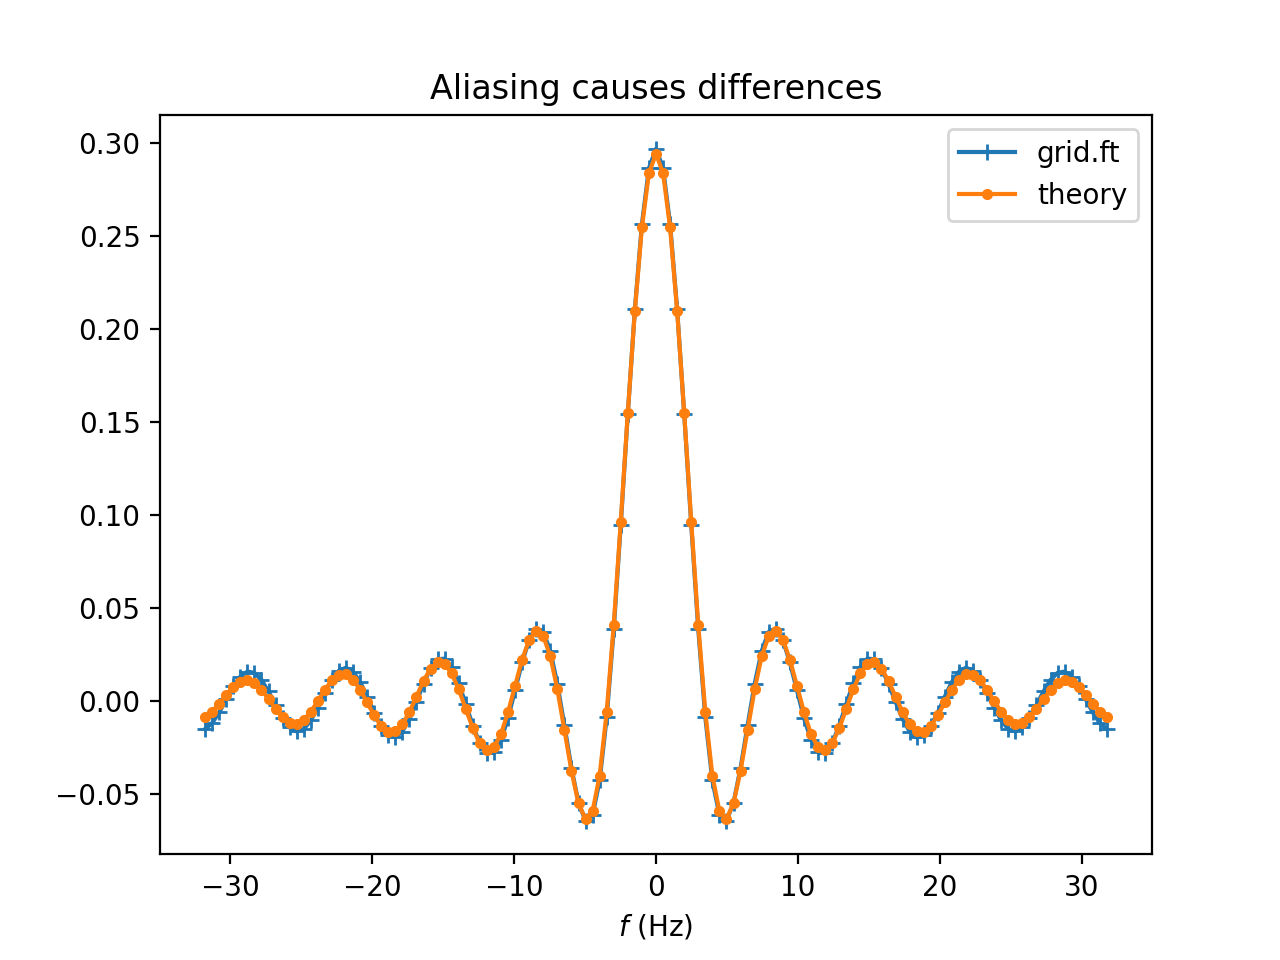

In [14]:
fig, ax = plt.subplots()
ax.plot(axis_Omega2.centers/(2*np.pi), x_Omega2, marker='+', label='grid.ft')
ax.plot(axis_Omega2.centers/(2*np.pi), x_Omega_theory2, marker='.', label='theory')
ax.legend()
ax.set_xlabel(r'$f$ (Hz)')
ax.set_title(r'Aliasing causes differences');

In [15]:
axis_ispectrum_theory, x_ispectrum_theory = axis_Omega.ispectrum(x_Omega_theory)

In [16]:
np.max(np.abs(np.imag(x_ispectrum_theory)))

0.0

<IPython.core.display.Javascript object>


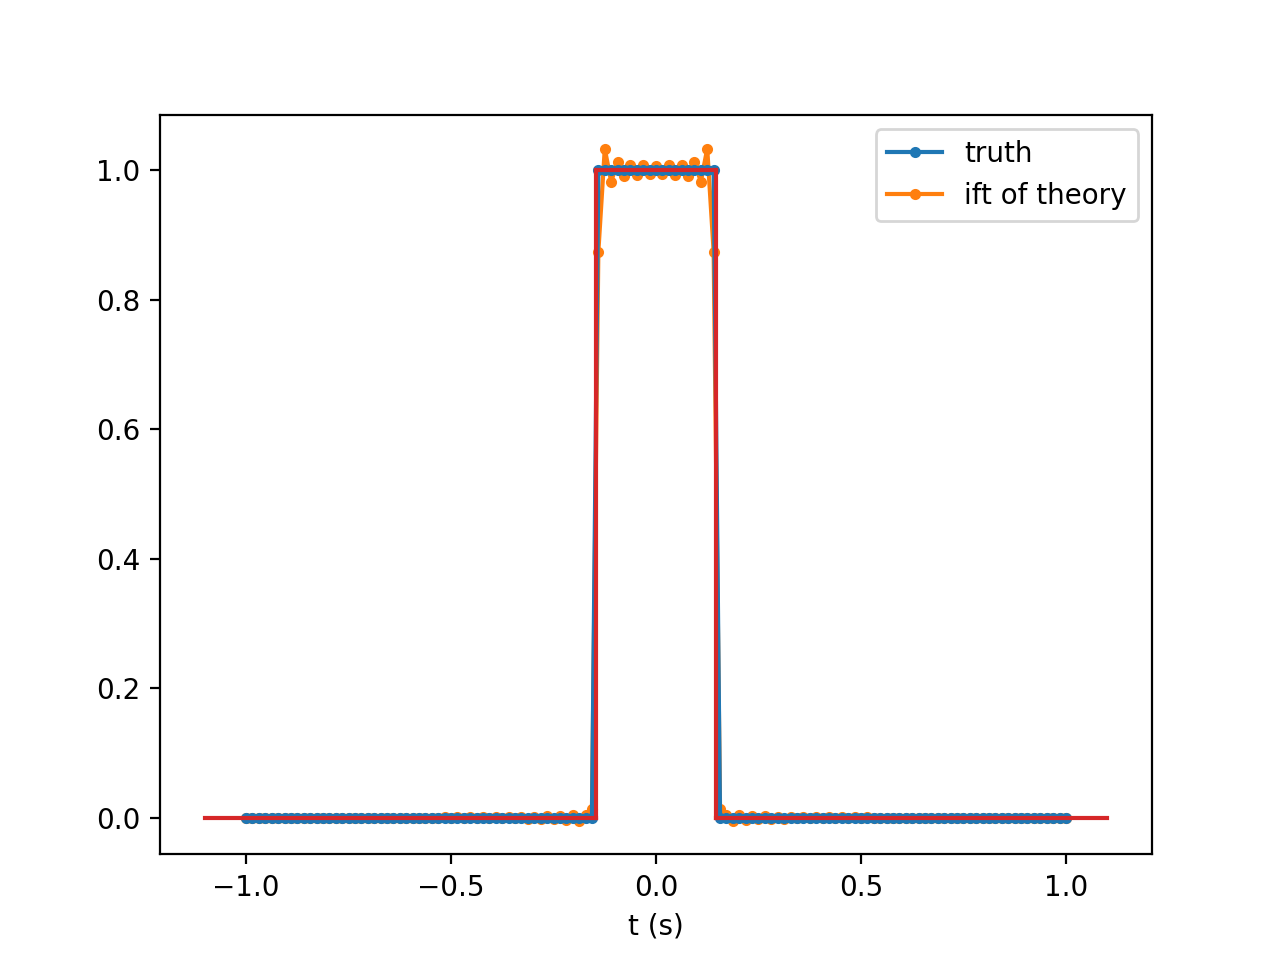

In [17]:
fig, ax = plt.subplots()
ax.plot(axis_t.centers, x, marker='.', label='truth')
ax.plot(axis_ispectrum_theory.centers, x_ispectrum_theory, marker='.', label='ift of theory', zorder=-10)
ax.plot([xmin, -1/(2*a)], [0, 0], c='C3')
ax.plot([-1/(2*a), -1/(2*a)], [0, 1], c='C3')
ax.plot([-1/(2*a), 1/(2*a)], [1, 1], c='C3')
ax.plot([1/(2*a), 1/(2*a)], [1, 0], c='C3')
ax.plot([1/(2*a), xmax], [0, 0], c='C3')
ax.set_xlabel('t (s)')
ax.legend();

## Gibbs phenomena

The oscillations and overshoot/overshoot observed are examples of Gibbs phenomena.

What we have computed in `x_ift_theory` is the inverse DFT (meant to approximate the inverse FT and is approximate because of aliasing and finite sampling) of a frequency windowed sinc. Let us go through the full derivation:

To begin, `x_ft_theory` are samples of the FT of $x(t) = \text{rect}(at)$ from $-f_n$ to $f_n$ where $f_n$ is the Nyquist frequency. We then have

\begin{equation}
w(t) * x(t) = \int_{-\infty}^{\infty} x(\tau)\, y(t - \tau)\, d\tau \overset{\mathfrak{F}}{\longleftrightarrow}  W(f)\, X(f)
\end{equation}

where $W(f) = \text{rect}(T_s f)$ and $f_N = f_s / 2 = 1 / (2T_s)$. The inverse Fourier transform of the frequency window is given by

\begin{equation}
w(t) = \text{sinc}\biggl(\frac{t}{T_s}\biggr) \frac{1}{T_s}
\end{equation}

Thus, we have

\begin{align}
y(t) &= \int_{-\infty}^\infty \text{sinc}\biggl(\frac{\tau}{T_s}\biggr) \frac{1}{T_s}\, \text{rect}[a(t-\tau)]\, d\tau \\
&= \frac{1}{\pi} \int_{\frac{\pi(2 a t - 1)}{2 a T_s}}^{\frac{\pi(2 a t + 1)}{2 a T_s}} \biggl(\frac{\sin x}{x}\biggr)\, dx \\
&= \frac{1}{\pi}S_i\biggl[\frac{\pi(2 a t + 1)}{2 a T_s}\biggr] - \frac{1}{\pi}S_i\biggl[\frac{\pi(2 a t - 1)}{2 a T_s}\biggr]
\end{align}
where $S_i$ is the sine integral function implemented by, e.g., `scipy.special.sici`.

In [18]:
axis_t8 = axis_t.oversample(8)

In [19]:
x_theory = 1/np.pi*scipy.special.sici(np.pi*(2*a*axis_t8.centers + 1)/(2*a*axis_t.T))[0] - 1/np.pi*scipy.special.sici(np.pi*(2*a*axis_t8.centers - 1)/(2*a*axis_t.T))[0]

<IPython.core.display.Javascript object>


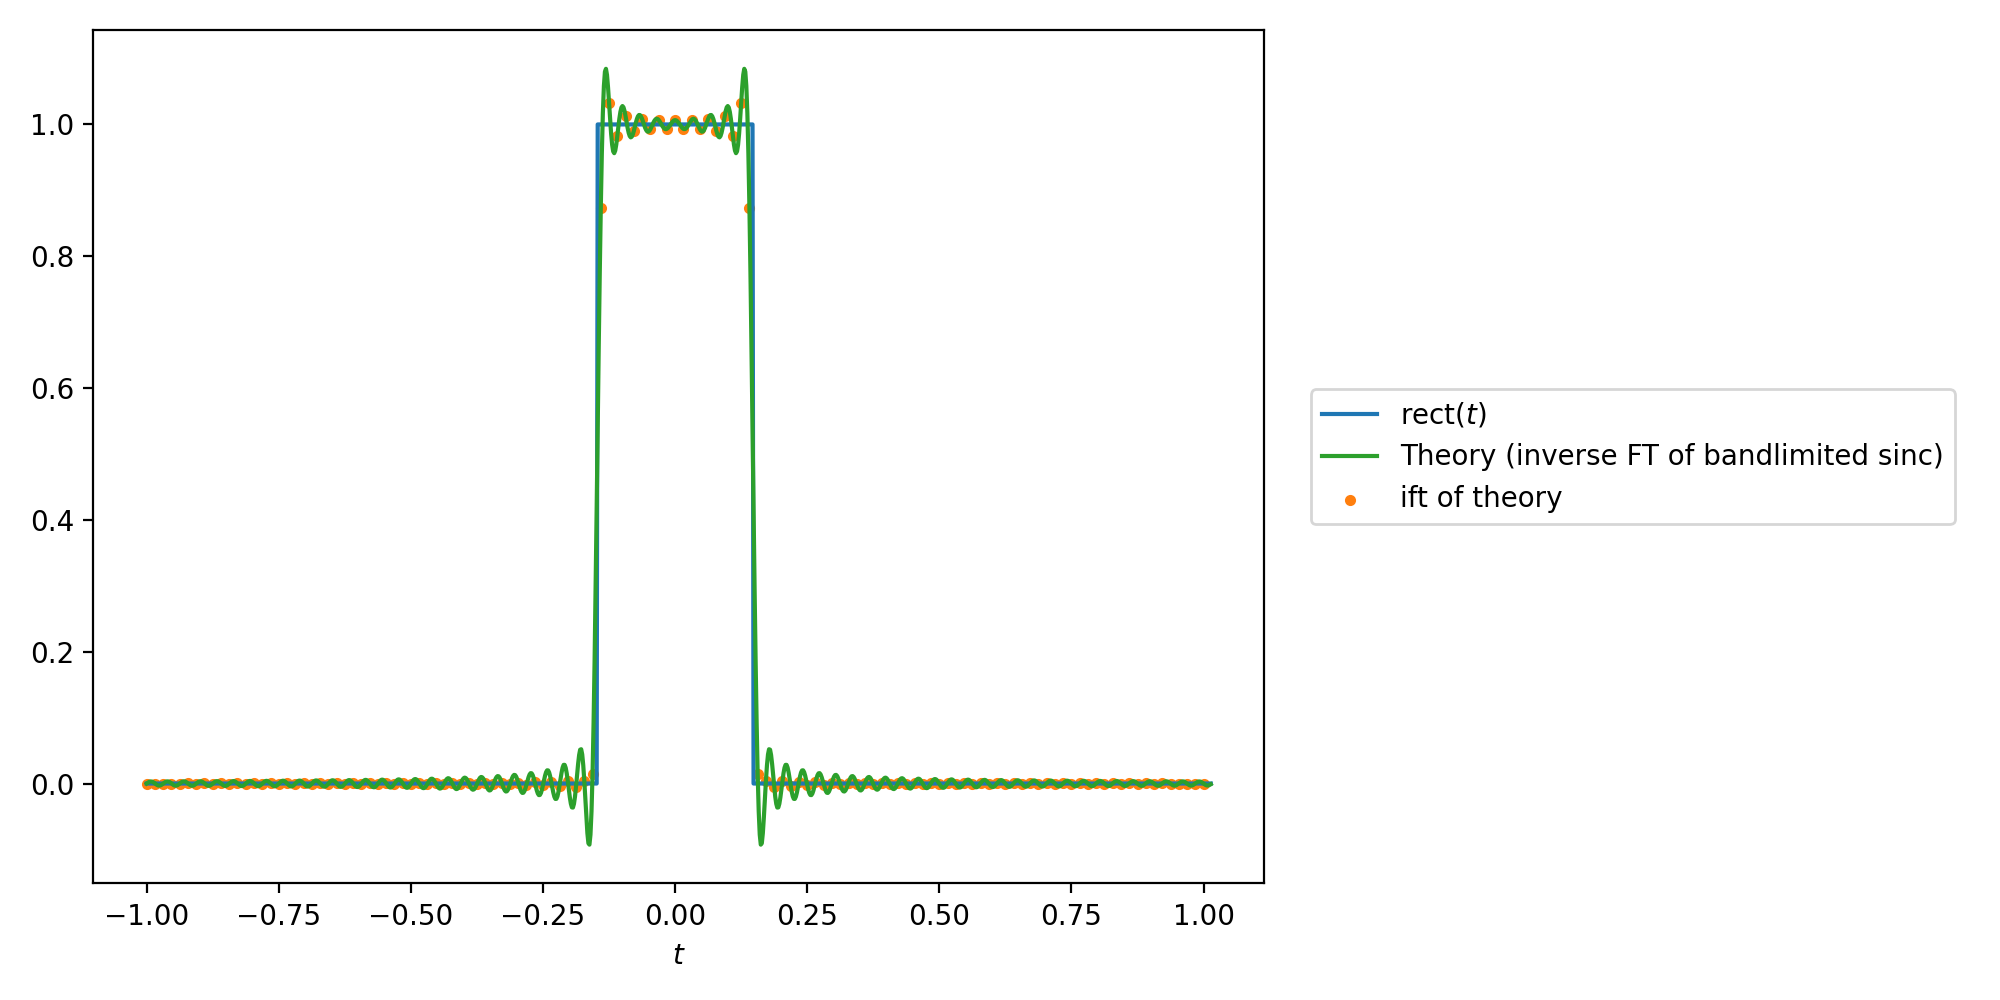

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(axis_t8, rect(a*axis_t8.centers), label=r'rect$(t)$', c='C0')
ax.scatter(axis_ispectrum_theory.centers, x_ispectrum_theory, marker='.', label='ift of theory', c='C1', zorder=-10)
ax.plot(axis_t8, x_theory, label='Theory (inverse FT of bandlimited sinc)', c='C2')
ax.set_xlabel(r'$t$')
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
fig.tight_layout()